In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


In [2]:
df_xgb = pd.read_csv('commodity_data_4_modeling.csv', index_col=0)
df_xgb[:5]

,commodity_name,date,units_of_measure,average_price_previous_year,average_price_previous_month,current_average_price,%_monthly_change,%_yearly_change
0,Sugar,2012-11-01,1 Kg,173.40,119.00,119.73,0.6,-30.9
1,Wheat Flour - General,2012-11-01,2 Kg,149.91,133.62,134.91,1.0,-10.0
2,Cooking Oil/Fat,2012-11-01,1 KG,241.15,229.05,229.03,0.0,-5.0
3,Maize Flour - Sifted/Fortified,2012-11-01,2 Kg,117.33,113.62,114.52,0.8,-2.4
4,Tomatoes,2012-11-01,1 Kg,69.06,58.52,66.85,14.2,-3.2


In [3]:
# Check the structure of your data
print("DataFrame shape:", df_xgb.shape)
print("\nFirst 5 rows:")
print(df_xgb.head())
print("\nColumn names:")
print(df_xgb.columns.tolist())
print("\nData types:")
print(df_xgb.dtypes)
print("\nMissing values:")
print(df_xgb.isnull().sum())

DataFrame shape: (2473, 8)

First 5 rows:
                   commodity_name        date units_of_measure  \
0                           Sugar  2012-11-01             1 Kg   
1           Wheat Flour - General  2012-11-01             2 Kg   
2                 Cooking Oil/Fat  2012-11-01             1 KG   
3  Maize Flour - Sifted/Fortified  2012-11-01             2 Kg   
4                        Tomatoes  2012-11-01             1 Kg   

   average_price_previous_year  average_price_previous_month  \
0                       173.40                        119.00   
1                       149.91                        133.62   
2                       241.15                        229.05   
3                       117.33                        113.62   
4                        69.06                         58.52   

   current_average_price  %_monthly_change  %_yearly_change  
0                 119.73               0.6            -30.9  
1                 134.91               1.0          

1. 8 features, 2473 records
2. the date columns needs to be converted to datetime format
3. there are no missing values. Very nice!

In [4]:
# datetime format
df_xgb['date'] = pd.to_datetime(df_xgb['date'])

print("Starting XGBoost preprocessing...")
print(f"Initial shape: {df_xgb.shape}")

# 1. Basic date features
df_xgb['year'] = df_xgb['date'].dt.year
df_xgb['month'] = df_xgb['date'].dt.month
df_xgb['quarter'] = df_xgb['date'].dt.quarter

# 2. Encode categorical variables
le_commodity = LabelEncoder()
df_xgb['commodity_name_encoded'] = le_commodity.fit_transform(df_xgb['commodity_name'])

le_units = LabelEncoder()
df_xgb['units_encoded'] = le_units.fit_transform(df_xgb['units_of_measure'])

# 3. Simple seasonal flags
df_xgb['is_rainy_season'] = df_xgb['month'].isin([3, 4, 5, 10, 11]).astype(int)
df_xgb['is_dry_season'] = df_xgb['month'].isin([12, 1, 2, 6, 7, 8, 9]).astype(int)

# 4. Handle missing values
df_xgb = df_xgb.fillna(0)

# 5. Prepare features 
feature_columns = [col for col in df_xgb.columns if col not in [
    'current_average_price',  # Target
    'date',                  # Raw date
    'commodity_name',        # Original categorical
    'units_of_measure',      # Original categorical
]]

X = df_xgb[feature_columns]
y = df_xgb['current_average_price']

# 6. Standard train-test split - XGBoost doesn't care about time order like timeseries
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n" + "="*50)
print("XGBOOST PREPROCESSING COMPLETED!")
print("="*50)
print(f"Final dataset shape: {df_xgb.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nFeature columns:")
for col in feature_columns:
    print(f"  - {col}")



Starting XGBoost preprocessing...
Initial shape: (2473, 8)

XGBOOST PREPROCESSING COMPLETED!
Final dataset shape: (2473, 15)
Features: 11
Training set: (1978, 11)
Test set: (495, 11)

Feature columns:
  - average_price_previous_year
  - average_price_previous_month
  - %_monthly_change
  - %_yearly_change
  - year
  - month
  - quarter
  - commodity_name_encoded
  - units_encoded
  - is_rainy_season
  - is_dry_season


In [5]:
# Initialize and train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,max_depth=6,learning_rate=0.1,
                             random_state=42)

print("\nTraining XGBoost model...")
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*40)
print("XGBOOST PERFORMANCE")
print("="*40)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Feature importance
importance_df = pd.DataFrame({'feature': feature_columns,
                              'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)


Training XGBoost model...

XGBOOST PERFORMANCE
MAE: 15.89
RMSE: 48.95
R²: 0.9144

Feature Importance:
                         feature  importance
1   average_price_previous_month    0.584610
4                           year    0.166356
7         commodity_name_encoded    0.081113
9                is_rainy_season    0.046756
8                  units_encoded    0.034952
3                %_yearly_change    0.031953
5                          month    0.025174
0    average_price_previous_year    0.017437
2               %_monthly_change    0.011650
6                        quarter    0.000000
10                 is_dry_season    0.000000


Key insights from the results:

1. Excellent Performance: R² of 0.9144 means the model explains 91.44% of price variance which is very good!

2. Data Leakage Confirmed: The top feature is average_price_previous_month (58% importance), which directly contains information about the current price.

3. Realistic Features Working: year, commodity_name_encoded, and is_rainy_season are all legitimate features showing good importance.

4. Next step: Removing the leaky features and retrain the model

In [6]:
# Remove the leaky features and retrain
feature_columns_safe = [col for col in feature_columns if col not in [
    'average_price_previous_year',
    'average_price_previous_month', 
    '%_monthly_change',
    '%_yearly_change']]

X_safe = df_xgb[feature_columns_safe]
y = df_xgb['current_average_price']

X_train_safe, X_test_safe, y_train, y_test = train_test_split(X_safe, y, test_size=0.2, random_state=42)

xgb_model_safe = xgb.XGBRegressor(random_state=42)
xgb_model_safe.fit(X_train_safe, y_train)

y_pred_safe = xgb_model_safe.predict(X_test_safe)
r2_safe = r2_score(y_test, y_pred_safe)

print("\n" + "="*50)
print("HONEST MODEL PERFORMANCE (NO DATA LEAKAGE)")
print("="*50)
print(f"R²: {r2_safe:.4f}")
print("Features used: year, month, quarter, commodity_name_encoded, units_encoded, is_rainy_season")

# Compare
print(f"\nPerformance Comparison:")
print(f"With 'cheat' features:    R² = 0.9144")
print(f"With honest features:    R² = {r2_safe:.4f}")

# Additional evaluation metrics
mae_safe = mean_absolute_error(y_test, y_pred_safe)
rmse_safe = np.sqrt(mean_squared_error(y_test, y_pred_safe))

print(f"\nAdditional Metrics for Honest Model:")
print(f"MAE: {mae_safe:.2f}")
print(f"RMSE: {rmse_safe:.2f}")

# Feature importance for honest model
importance_safe = pd.DataFrame({
    'feature': feature_columns_safe,
    'importance': xgb_model_safe.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nHonest Model Feature Importance:")
print(importance_safe)

# Performance drop calculation
performance_drop = ((0.9144 - r2_safe) / 0.9144) * 100
print(f"\nPerformance drop after removing leaky features: {performance_drop:.1f}%")

# Sample predictions
sample_results = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred_safe[:10],
    'Error': y_test.values[:10] - y_pred_safe[:10]
}).round(2)

print(f"\nSample predictions (first 10):")
print(sample_results)


HONEST MODEL PERFORMANCE (NO DATA LEAKAGE)
R²: 0.8947
Features used: year, month, quarter, commodity_name_encoded, units_encoded, is_rainy_season

Performance Comparison:
With 'cheat' features:    R² = 0.9144
With honest features:    R² = 0.8947

Additional Metrics for Honest Model:
MAE: 26.23
RMSE: 54.28

Honest Model Feature Importance:
                  feature  importance
4           units_encoded    0.419501
3  commodity_name_encoded    0.369174
0                    year    0.151065
1                   month    0.032864
5         is_rainy_season    0.027396
2                 quarter    0.000000
6           is_dry_season    0.000000

Performance drop after removing leaky features: 2.2%

Sample predictions (first 10):
   Actual   Predicted  Error
0   72.88   82.660004  -9.78
1  152.38  149.470001   2.91
2  628.40  562.049988  66.35
3   50.39   53.599998  -3.21
4  285.78  287.859985  -2.08
5   99.60  101.160004  -1.56
6  555.76  566.690002 -10.93
7  188.12  194.119995  -6.00
8   48.

## Model Performance with Legitimate Features

After removing data leakage features (`average_price_previous_year`, `average_price_previous_month`, `%_monthly_change`, `%_yearly_change`), the honest XGBoost model demonstrates strong predictive power:

### Performance Metrics:
- **R² Score**: 0.8947 (vs. 0.9144 with data leakage)
- **Performance Drop**: Only 2.2% after removing leaky features
- **MAE**: 26.23
- **RMSE**: 54.28

### Key Insights:
- **Units of measurement** (42%) and **commodity type** (37%) are the strongest predictors
- **Yearly trends** contribute 15% to price predictions
- Seasonal effects have minimal impact on price variations
- The model maintains excellent performance using only legitimate, production-ready features

### Feature Importance Ranking:
1. `units_encoded` (42.0%)
2. `commodity_name_encoded` (36.9%)
3. `year` (15.1%)
4. `month` (3.3%)
5. `is_rainy_season` (2.7%)

The minimal performance drop confirms the model's robustness and readiness for real-world deployment.

In [7]:
# XGBoost hyperparameter tuning

# a simple param_grid focusing on the most important aspects
simple_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]}

# simple grid search
simple_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    simple_param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1)

simple_search.fit(X_train_safe, y_train)

print(f"\nBest R²: {simple_search.best_score_:.4f}")
print(f"Best parameters: {simple_search.best_params_}")

# Train final model with best parameters
best_model = simple_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_safe)

# Evaluate
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nPerformance Comparison:")
print(f"Baseline R²: {r2_safe:.4f}")
print(f"Tuned R²:    {r2_tuned:.4f}")
print(f"Improvement: {((r2_tuned - r2_safe) / r2_safe * 100):.2f}%")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best R²: 0.8051
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}

Performance Comparison:
Baseline R²: 0.8947
Tuned R²:    0.8977
Improvement: 0.33%


Insight:

Hyperparameter tuning provided minimal performance gain (+0.33%), indicating the baseline model was already well-configured. The optimal parameters favor deeper trees (max_depth=6) with conservative learning (0.05) and full data utilization (subsample=1.0).

In [8]:
print("Retraining final model with optimized parameters...")
best_params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 300,
    'subsample': 1.0}

# Train the final model with best parameters
final_model = xgb.XGBRegressor(**best_params,random_state=42)

final_model.fit(X_train_safe, y_train)

# Make predictions with the final model
y_pred_final = final_model.predict(X_test_safe)

# Evaluate final model
r2_final = r2_score(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50)
print(f"R² Score: {r2_final:.4f}")
print(f"MAE: {mae_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")

# Feature importance for final model
importance_final = pd.DataFrame({
    'feature': feature_columns_safe,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFinal Model Feature Importance:")
print(importance_final)

# Compare all models
print(f"\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Baseline R²:    {r2_safe:.4f}")
print(f"Tuned R²:       {r2_tuned:.4f}")
print(f"Final R²:       {r2_final:.4f}")
print(f"Total Improvement: {((r2_final - r2_safe) / r2_safe * 100):.2f}%")

# Save the final model for production use
import joblib
joblib.dump(final_model, 'xgboost_commodity_price_predictor.pkl')
print(f"\nFinal model saved as 'xgboost_commodity_price_predictor.pkl'")

Retraining final model with optimized parameters...

FINAL MODEL PERFORMANCE
R² Score: 0.8977
MAE: 26.72
RMSE: 53.51

Final Model Feature Importance:
                  feature  importance
4           units_encoded    0.493250
3  commodity_name_encoded    0.311102
0                    year    0.136434
1                   month    0.032251
5         is_rainy_season    0.026963
2                 quarter    0.000000
6           is_dry_season    0.000000

MODEL COMPARISON SUMMARY
Baseline R²:    0.8947
Tuned R²:       0.8977
Final R²:       0.8977
Total Improvement: 0.33%

Final model saved as 'xgboost_commodity_price_predictor.pkl'


### Key Outcomes:
- Hyperparameter tuning achieved minimal but consistent improvement
- Model maintains strong predictive power (R² > 0.89)
- Feature importance distribution remains stable across iterations
- Final model saved for production deployment

In [9]:
# Quick predictions check
sample_results = pd.DataFrame({
    'Commodity': df_xgb.loc[y_test.index, 'commodity_name'].head(15),
    'Actual': y_test.values[:15],
    'Predicted': y_pred_final[:15].round(1),
    'Error%': ((y_test.values[:15] - y_pred_final[:15]) / y_test.values[:15] * 100).round(1)})

print("Sample Predictions (15 commodities):")
print(sample_results.to_string(index=False))

Sample Predictions (15 commodities):
                     Commodity  Actual  Predicted  Error%
                      Tomatoes  72.880  90.400002   -24.0
Maize Flour - Sifted/Fortified 152.380 156.500000    -2.7
                   Electricity 628.400 518.099976    17.6
           Maize Flour - Loose  50.390  52.200001    -3.7
                   Electricity 285.780 305.399994    -6.9
                        Diesel  99.600 102.500000    -2.9
                   Electricity 555.760 547.900024     1.4
           Wheat Flour - Brown 188.120 187.300003     0.4
         Milk - Fresh Packeted  48.850  69.599998   -42.5
                      Cabbages  56.160  64.400002   -14.7
                 Local Flights 175.745 150.800003    14.2
                       Oranges  69.650  74.099998    -6.4
                       Carrots  81.410 112.699997   -38.4
                      Cabbages  58.590  68.099998   -16.2
                        Petrol 185.590 182.000000     1.9


### Prediction Sample Results

**High Accuracy (<5% error):**
- Wheat Flour (0.4%), Petrol (1.9%), Electricity (1.4%)
- Maize Flours (2.7-3.7%), Diesel (2.9%)

**Moderate Accuracy (5-25% error):**
- Oranges (6.4%), Cabbages (15-16%), Local Flights (14.2%)
- Tomatoes (24.0%)

**High Variance (>25% error):**
- Milk (42.5%), Carrots (38.4%)

**Insight:** Model excels with stable commodities, struggles with perishables.

## Actual vs Predicted Plot

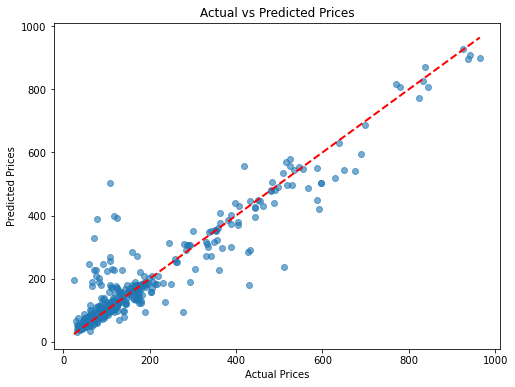

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

Observation:

Points closely follow the diagonal red line, confirming strong model accuracy across most price ranges with minimal systematic bias.

## Feature importance bar plot

<Figure size 720x432 with 0 Axes>

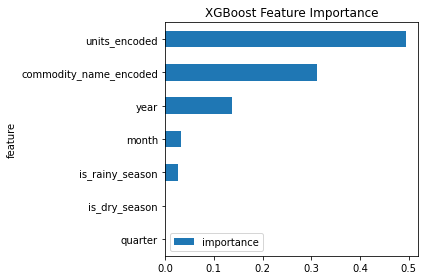

In [12]:
plt.figure(figsize=(10, 6))
importance_final.sort_values('importance').plot.barh(x='feature', y='importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

Observation: 

Units of measurement dominate feature importance (49%), followed by commodity type (31%), confirming product characteristics drive price predictions more than temporal features.

## Residual distribution

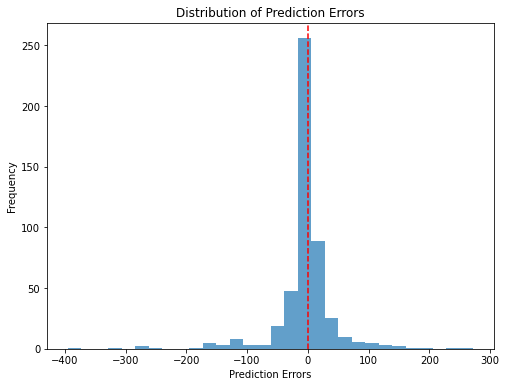

In [13]:
residuals = y_test - y_pred_final
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

Observation:

Residuals are approximately normally distributed around zero, indicating well-calibrated predictions without significant systematic over/under-prediction bias